# Facial keypoints

In [1]:
import numpy as np

import torch, torch.utils.data
import torchvision
from torchvision.models.resnet import BasicBlock

import matplotlib.pyplot as plt

import lib.pytorch_trainer as ptt
use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: True


## Train file

In [2]:
npzfile = np.load('/data/datasets/facial_features/train.npz')
x, y = npzfile['x'], npzfile['y']
print(x.dtype, x.shape, x.min(), x.max())
print(y.dtype, y.shape, y.min(), y.max())

uint8 (7000, 1, 96, 96) 0 255
float32 (7000, 8) 0.686592 95.80898


## Test file

In [3]:
npzfile = np.load('/data/datasets/facial_features/test.npz')
x = npzfile['x']
print(x.dtype, x.shape, x.min(), x.max())

uint8 (1783, 1, 96, 96) 0 255


## Dataset

In [4]:
class DatasetFacialKeypoints(torch.utils.data.Dataset):
    def __init__(self, filepath, train=True, split=.8, transform=None):
        super().__init__()
        self.transform = transform
        npzfile = np.load(filepath)
        x = npzfile['x']
        try:
            y = npzfile['y']
        except KeyError:
            y = None
        if y is not None:
            n_train = int(np.round(x.shape[0] * split))
            if train:
                self.x = x[:n_train]
                self.y = y[:n_train]
            else:
                self.x = x[n_train:]
                self.y = y[n_train:]
        else:
            self.x = x
            self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        if self.transform is not None:
            xi = self.transform(self.x[idx].repeat(3, axis=0).transpose(1, 2, 0))
        else:
            xi = self.x[idx]
        if self.y is None:
            yi = None
        else:
            yi = torch.FloatTensor(self.y[idx])
        return xi, yi

In [5]:
ds_train = DatasetFacialKeypoints('/data/datasets/facial_features/train.npz', train=True, transform=torchvision.transforms.ToTensor())
ds_valid = DatasetFacialKeypoints('/data/datasets/facial_features/train.npz', train=False, transform=torchvision.transforms.ToTensor())
ds_test = DatasetFacialKeypoints('/data/datasets/facial_features/test.npz', transform=torchvision.transforms.ToTensor())
for ds in [ds_train, ds_valid, ds_test]:
    x, y = next(iter(ds))
    print(len(ds))
    print(type(x), x.shape, x.min(), x.max())
    if y is not None:
        print(type(y), y.shape, y.min(), y.max())
    else:
        print(type(y))
    print()

5600
<class 'torch.FloatTensor'> torch.Size([3, 96, 96]) 0.007843137718737125 0.9921568632125854
<class 'torch.FloatTensor'> torch.Size([8]) 30.227006912231445 84.48577117919922

1400
<class 'torch.FloatTensor'> torch.Size([3, 96, 96]) 0.0 1.0
<class 'torch.FloatTensor'> torch.Size([8]) 27.133085250854492 79.06320190429688

1783
<class 'torch.FloatTensor'> torch.Size([3, 96, 96]) 0.0 0.7490196228027344
<class 'NoneType'>



In [6]:
loader_train = torch.utils.data.DataLoader(ds_train, batch_size=len(ds_train), shuffle=True)
loader_valid = torch.utils.data.DataLoader(ds_valid, batch_size=len(ds_valid), shuffle=False)
loader_test = torch.utils.data.DataLoader(ds_test, batch_size=len(ds_test), shuffle=False)
x_train, y_train = next(iter(loader_train))
print(x_train.size(), y_train.size())
x_valid, y_valid = next(iter(loader_valid))
print(x_valid.size(), y_valid.size())

torch.Size([5600, 3, 96, 96]) torch.Size([5600, 8])
torch.Size([1400, 3, 96, 96]) torch.Size([1400, 8])


## Model (modified resnet18, convolutional layer1 transfer learning)

In [7]:
class MyResNetConv(torchvision.models.ResNet):
    def __init__(self):
        super().__init__(BasicBlock, [2, 2, 2, 2])
        self.load_state_dict(torch.utils.model_zoo.load_url(
            'https://download.pytorch.org/models/resnet18-5c106cde.pth'))
        del self.layer2
        del self.layer3
        del self.layer4
        del self.fc
        for param in self.parameters():
            param.requires_grad = False
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

class MyResNetDens(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dens1 = torch.nn.Linear(in_features=20736, out_features=100)
        self.dens2 = torch.nn.Linear(in_features=100, out_features=8)
    def forward(self, x):
        x = self.dens1(x)
        x = torch.nn.functional.selu(x)
        x = self.dens2(x)
        return x

class MyResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mrnc = MyResNetConv()
        self.mrnd = MyResNetDens()
    def forward(self, x):
        x = self.mrnc(x)
        x = self.mrnd(x)
        return x

model = MyResNet()
if use_gpu:
    model = model.cuda()
print(model)

MyResNet(
  (mrnc): MyResNetConv(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size

## Features

In [8]:
inp_train = x_train
inp_valid = x_valid
if use_gpu:
    inp_train = inp_train.cuda()
    inp_valid = inp_valid.cuda()
inp_train = torch.autograd.Variable(inp_train)
inp_valid = torch.autograd.Variable(inp_valid)

feat_train = model.mrnc(inp_train).data
feat_valid = model.mrnc(inp_valid).data

print(feat_train.size())
print(feat_valid.size())

torch.Size([5600, 20736])
torch.Size([1400, 20736])


## Training (using features from transfer learning)

In [9]:
n_epochs = 500
criterion = torch.nn.MSELoss()
optm = torch.optim.RMSprop(params=model.mrnd.parameters(), lr=1e-4)
cb_chkpt = ptt.ModelCheckpoint('../../models/facialfeatures', reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(model         = model.mrnd,
                             criterion     = criterion,
                             optimizer     = optm,
                             callbacks = [ptt.PrintCallback(),
                                          cb_chkpt
                                         ])

In [10]:
train = False
if train:
    trainer.fit(n_epochs   = n_epochs,
                Xin        = feat_train,
                Yin        = y_train,
                shuffle    = True,
                batch_size = 100,
                valid_data = (feat_valid, y_valid))
else:
    trainer.load_state('/data/models/facialfeatures')

Start training for 500 epochs
  1:   0.2s   T: 160.98346   V: 23.12263 best
  2:   0.1s   T: 21.16303   V: 21.24611 best
  3:   0.1s   T: 19.25749   V: 20.18374 best
  4:   0.1s   T: 17.53474   V: 18.64171 best
  5:   0.1s   T: 16.06615   V: 17.57392 best
  6:   0.1s   T: 14.85453   V: 17.37891 best
  7:   0.1s   T: 13.95333   V: 15.82351 best
  8:   0.1s   T: 13.36259   V: 14.72569 best
  9:   0.1s   T: 13.09514   V: 14.11213 best
 10:   0.1s   T: 12.23536   V: 13.95063 best
 11:   0.1s   T: 11.96494   V: 16.12540 
 12:   0.1s   T: 11.68491   V: 14.09834 
 13:   0.1s   T: 11.27988   V: 12.49162 best
 14:   0.1s   T: 10.77952   V: 19.47538 
 15:   0.1s   T: 10.63556   V: 12.02740 best
 16:   0.1s   T: 10.05803   V: 12.28867 
 17:   0.1s   T: 10.42549   V: 14.36009 
 18:   0.1s   T: 9.90714   V: 13.50880 
 19:   0.1s   T: 9.64600   V: 12.96319 
 20:   0.1s   T: 9.55420   V: 11.15318 best
 21:   0.1s   T: 9.47933   V: 11.15654 
 22:   0.1s   T: 9.06966   V: 12.44388 
 23:   0.1s   T: 9.2

206:   0.1s   T: 4.80694   V: 8.05455 
207:   0.1s   T: 4.96057   V: 7.83535 
208:   0.1s   T: 4.86460   V: 7.89408 
209:   0.1s   T: 4.99263   V: 8.29874 
210:   0.1s   T: 4.98329   V: 7.45536 
211:   0.1s   T: 4.81923   V: 8.01373 
212:   0.1s   T: 4.93016   V: 10.84155 
213:   0.1s   T: 4.73512   V: 8.44407 
214:   0.1s   T: 5.00132   V: 10.78310 
215:   0.1s   T: 4.86077   V: 7.22300 best
216:   0.1s   T: 4.77955   V: 7.49929 
217:   0.1s   T: 5.01400   V: 7.24007 
218:   0.1s   T: 4.55255   V: 8.41923 
219:   0.1s   T: 5.03670   V: 7.37403 
220:   0.1s   T: 4.74631   V: 7.75798 
221:   0.1s   T: 4.87198   V: 8.05755 
222:   0.1s   T: 4.63403   V: 7.20214 best
223:   0.1s   T: 4.96107   V: 7.91842 
224:   0.1s   T: 4.60630   V: 7.04016 best
225:   0.1s   T: 4.97329   V: 7.12341 
226:   0.1s   T: 4.60107   V: 7.43999 
227:   0.1s   T: 5.01535   V: 6.81431 best
228:   0.1s   T: 4.76058   V: 8.22843 
229:   0.1s   T: 4.71087   V: 12.65776 
230:   0.1s   T: 4.88081   V: 8.18180 
231:  

417:   0.1s   T: 3.77304   V: 6.74058 
418:   0.1s   T: 3.64706   V: 7.00683 
419:   0.1s   T: 3.66209   V: 6.43718 
420:   0.1s   T: 3.74623   V: 9.64983 
421:   0.1s   T: 3.75495   V: 8.05120 
422:   0.1s   T: 3.65414   V: 7.79601 
423:   0.1s   T: 3.73098   V: 7.66574 
424:   0.1s   T: 3.74112   V: 7.46954 
425:   0.1s   T: 3.68302   V: 10.99443 
426:   0.1s   T: 3.65137   V: 7.18412 
427:   0.1s   T: 3.69986   V: 6.73740 
428:   0.1s   T: 3.62574   V: 6.74558 
429:   0.1s   T: 3.72604   V: 6.79879 
430:   0.1s   T: 3.61315   V: 7.70176 
431:   0.1s   T: 3.61651   V: 7.42654 
432:   0.1s   T: 3.80965   V: 8.12598 
433:   0.1s   T: 3.58102   V: 8.24516 
434:   0.1s   T: 3.65713   V: 7.72632 
435:   0.1s   T: 3.63991   V: 6.83938 
436:   0.1s   T: 3.73235   V: 8.35442 
437:   0.1s   T: 3.53474   V: 8.07950 
438:   0.1s   T: 3.69278   V: 7.87488 
439:   0.1s   T: 3.75894   V: 9.36272 
440:   0.1s   T: 3.44090   V: 7.28082 
441:   0.1s   T: 3.82120   V: 7.76864 
442:   0.1s   T: 3.32570

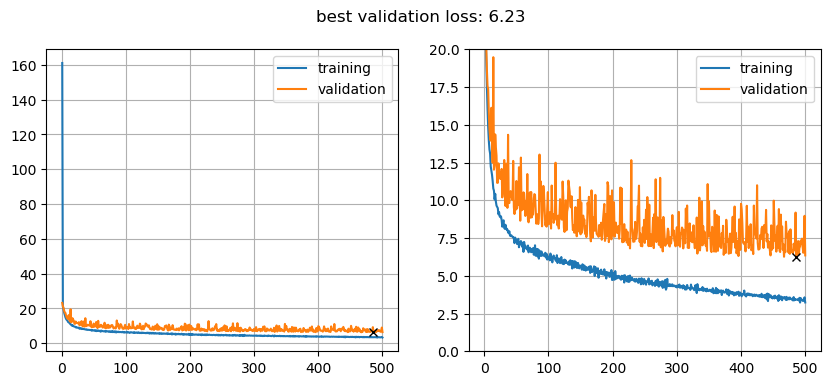

In [11]:
idx = np.argmin(trainer.metrics['valid']['losses'])
a_epochs = np.arange(1, 1 + len(trainer.metrics['valid']['losses']))
fig = plt.figure(figsize=(10, 4), dpi=100)
fig.suptitle('best validation loss: {:.2f}'.format(trainer.metrics['valid']['losses'][idx]))
ax = fig.add_subplot(1, 2, 1)
ax.plot(a_epochs, trainer.metrics['train']['losses'], label='training')
ax.plot(a_epochs, trainer.metrics['valid']['losses'], label='validation')
ax.plot(idx + 1, trainer.metrics['valid']['losses'][idx], 'kx')
# ax.set_yscale('log')
ax.legend()
ax.grid(True)
ax = fig.add_subplot(1, 2, 2)
ax.plot(a_epochs, trainer.metrics['train']['losses'], label='training')
ax.plot(a_epochs, trainer.metrics['valid']['losses'], label='validation')
ax.plot(idx + 1, trainer.metrics['valid']['losses'][idx], 'kx')
ax.set_ylim(0., 20.)
ax.legend()
ax.grid(True)
plt.show()

## Results

In [12]:
loader_valid = torch.utils.data.DataLoader(ds_valid, batch_size=1, shuffle=False)
l_loss = list()
l_output = list()
model.eval()
for x_valid, y_valid in loader_valid:
    if use_gpu:
        inp = torch.autograd.Variable(x_valid.cuda())
        tgt = torch.autograd.Variable(y_valid.cuda())
    else:
        inp = torch.autograd.Variable(x_valid)
        tgt = torch.autograd.Variable(y_valid)
    out = model(inp)
    l_loss.append(criterion(out, tgt).cpu().data.numpy()[0])
    l_output.append(out.cpu().data.numpy().tolist())
a_loss = np.array(l_loss, dtype=np.float)
a_output = np.array(l_output, dtype=np.float)

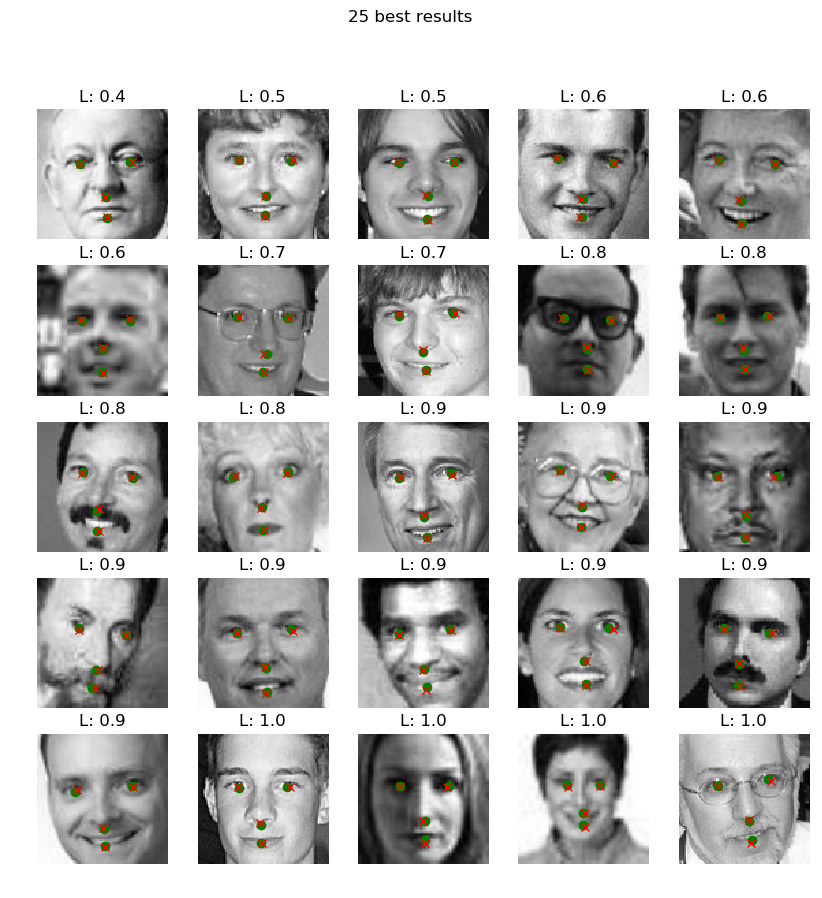

In [13]:
h, w = 5, 5
idxs_order = np.argsort(a_loss)
fig = plt.figure(figsize=(2 * w, 2 * h), dpi=100)
fig.suptitle('{} best results'.format(h * w))
for i_img, i_order in enumerate(idxs_order[:h * w]):
    ax = fig.add_subplot(h, w, 1 + i_img)
    ax.set_title('L: {:.1f}'.format(l_loss[i_order]))
    x, y = ds_valid[i_order]
    a_y = y.cpu().numpy().reshape(-1, 2)
    a_o = a_output[i_order].reshape(-1, 2)
    ax.imshow(x[0].cpu().numpy(), cmap='gray')
    ax.plot(a_y[:, 0], a_y[:, 1], 'go')
    ax.plot(a_o[:, 0], a_o[:, 1], 'rx')
    ax.axis('off')
plt.show()

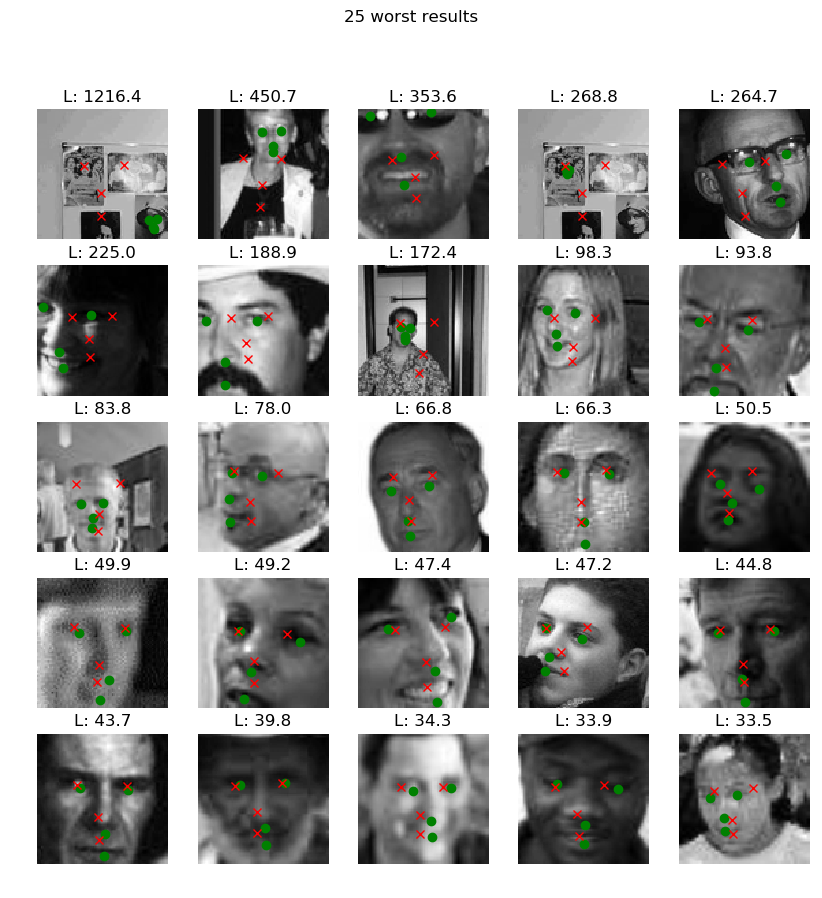

In [14]:
h, w = 5, 5
idxs_order = np.argsort(a_loss)
fig = plt.figure(figsize=(2 * w, 2 * h), dpi=100)
fig.suptitle('{} worst results'.format(h * w))
for i_img, i_order in enumerate(idxs_order[:-h * w - 1: -1]):
    ax = fig.add_subplot(h, w, 1 + i_img)
    ax.set_title('L: {:.1f}'.format(l_loss[i_order]))
    x, y = ds_valid[i_order]
    a_y = y.cpu().numpy().reshape(-1, 2)
    a_o = a_output[i_order].reshape(-1, 2)
    ax.imshow(x[0].cpu().numpy(), cmap='gray')
    ax.plot(a_y[:, 0], a_y[:, 1], 'go')
    ax.plot(a_o[:, 0], a_o[:, 1], 'rx')
    ax.axis('off')
plt.show()

## Exercícios

1. Analise os dados anotados: o que é a entrada e o que é a saída.
2. Este é um problema de regressão ou de classificação?
3. Qual é a medida de desempenho?